# BTC Strategy Design
***
## Import Package and Route

In [2]:
from datetime import datetime
from reference.Strategy import zwpy_sta
import pathlib
import backtrader as bt
import pyfolio as pf
import pandas as pd
import json
import backtrader.analyzers as btanalyzers

# route init
curr_folder = pathlib.Path().cwd()
BTC_data_min = curr_folder / "data" / "BTCUSDT_UPERP_1m.csv"

# report folder init
report_folder = curr_folder / "report"
if not report_folder.exists():
    report_folder.mkdir(parents=True, exist_ok=True)

data_folder = curr_folder / "data"
if not data_folder.exists():
    data_folder.mkdir(parents=True, exist_ok=True)



/home/thomas/Desktop/BTC/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## Data Resample

In [2]:
# 分k轉時k
BTC_data_min = pd.read_csv(BTC_data_min, parse_dates =["datetime"], index_col ="datetime")
print("Minute ohlc\n", BTC_data_min.head(10))
BTC_data = BTC_data_min.resample('h').mean()
print("\nHour ohlc\n", BTC_data.head(10))

# Cutting data
train = BTC_data[BTC_data.index < '2021-01-01 0:00:00']
test = BTC_data[BTC_data.index >= '2021-01-01 0:00:00']
print(f"count of training set:{train.shape[0]} {round(train.shape[0]/BTC_data.shape[0]*100, 2)}%")
print(f"count of testing set:{test.shape[0]} {round(test.shape[0]/BTC_data.shape[0]*100, 2)}%")

# Save to csv file
BTC_data.to_csv(str(data_folder / "BTC_hour.csv"))
train.to_csv(data_folder / "training_set.csv")
test.to_csv(data_folder / "testing_set.csv")
BTC_data = pathlib.Path().cwd() / "data" / "BTC_hour.csv"

Minute ohlc
                         open     high      low    close  volume
datetime                                                       
2019-09-25 15:44:00  8323.22  8348.51  8323.22  8345.08  15.878
2019-09-25 15:45:00  8346.57  8348.32  8339.09  8339.09  15.931
2019-09-25 15:46:00  8340.21  8341.79  8320.05  8320.77  29.408
2019-09-25 15:47:00  8320.77  8338.87  8320.77  8336.79  40.464
2019-09-25 15:48:00  8336.79  8342.28  8329.25  8340.73  34.654
2019-09-25 15:49:00  8343.46  8343.89  8338.15  8343.86  33.772
2019-09-25 15:50:00  8341.07  8364.00  8341.07  8360.93  43.837
2019-09-25 15:51:00  8359.17  8379.33  8352.64  8374.18  43.769
2019-09-25 15:52:00  8375.08  8380.26  8367.21  8374.61  55.568
2019-09-25 15:53:00  8374.02  8374.02  8343.37  8346.06  26.116

Hour ohlc
                             open         high          low        close  \
datetime                                                                  
2019-09-25 15:00:00  8343.848750  8353.017500  8334.82062

 ## Strategy
    Rule:
        If MACD - MACD_signal > 0: buy.
        If MACD - MACD_signal < 0: sell.

    Args:
        fast_period (int): fast ema period.
        slow_period (int): slow ema period.
        signal_period (int): macd signal period.

## Optimize params
***


### 透過訓練集優化參數，以sharp ratio為篩選條件

In [3]:
BTC_train_data = pathlib.Path().cwd() / "data" / "training_set.csv"

cerebro = bt.Cerebro()

# 使用optstrategy調整參數 策略檔位置('./reference/Strategy/zwpy_sta.py'class MacdV2Strategy)
cerebro.optstrategy(
            zwpy_sta.MacdV2Strategy,
            fast_period = range(10,14),
            slow_period = range(24,28),
            signal_period = range(8,12))

# 設置初始資金
cerebro.broker.setcash(100000)

# 設定資料格式
dt_start = datetime.strptime("20190925","%Y%m%d")
dt_end = datetime.strptime("20211028","%Y%m%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_train_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,          
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)

# 將backtrader回測結果放在各種analyzer中
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns")
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe", timeframe=bt.TimeFrame.Months)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()

# 將回測結果輸出成dataframe 並儲存csv檔
par_list = [[ele[0].params.fast_period, 
            ele[0].params.slow_period,
            ele[0].params.signal_period,
            ele[0].analyzers.returns.get_analysis()['rtot'], 
            ele[0].analyzers.sharpe.get_analysis()['sharperatio']
            ] for ele in results]
par_df = pd.DataFrame(par_list, columns = ['fast_period', 'slow_period', 'signal_period', 'return', 'sharpe'])
par_df.sort_values(by=['sharpe'], ascending=False, inplace=True)
par_df.to_csv(report_folder / 'train_result.csv', index=False)


printlog: printlog:False
period_me1:printlog:printlog: printlog:  
 printlog:
False10FalseFalse period_me1:period_me1:Falseprintlog:  
printlog:10
False
   
period_me1:period_me2:10period_me1:False 
 

period_me1:10Falseperiod_me1: period_me2:
1024 period_me2: 


period_signal: 2510period_me2:period_me1:
 
  period_me2:8 102424period_signal:
period_me2:25
  
period_signal: period_me2:

period_signal:8 period_signal: 24
 11 
109

25=== Backtesting Start! ===10

period_signal:period_signal: === Backtesting Start! ===11


period_me2:
=== Backtesting Start! ====== Backtesting Start! === 
=== Backtesting Start! ===
=== Backtesting Start! ===
 
25
10
=== Backtesting Start! ===
period_signal: 9
=== Backtesting Start! ===
2020-12-31, Ending Value 118631.772020-12-31, Ending Value 119393.00

2020-12-31, Ending Value 118438.05
2020-12-31, Ending Value 118652.17
2020-12-31, Ending Value 117921.21
2020-12-31, Ending Value 119026.43
2020-12-31, Ending Value 118172.56
2020-12-31, Ending Value 119172

In [4]:
train_result = pd.read_csv(report_folder / "train_result.csv")
print("traing_set\n", train_result)

traing_set
     fast_period  slow_period  signal_period    return    sharpe
0            10           25              8  0.166976  0.688950
1            10           26              8  0.167725  0.678062
2            10           27              8  0.179311  0.676713
3            11           24              8  0.175143  0.674622
4            10           24              9  0.169220  0.648561
..          ...          ...            ...       ...       ...
59           13           27             11  0.180953  0.571384
60           10           26             10  0.173596  0.570364
61           10           27             10  0.172024  0.570192
62           13           25              8  0.173133  0.569089
63           11           26              9  0.173462  0.568630

[64 rows x 5 columns]


## 由訓練結果得知，(10, 25, 8)為最佳參數(for sharpe ratio)

### 利用最佳參數進行完整回測 

Starting Value: 100000.00
printlog: False
period_me1: 10
period_me2: 25
period_signal: 8
=== Backtesting Start! ===
2021-10-28, Ending Value 133859.61
Ending Value: 133859.61


<IPython.core.display.Javascript object>


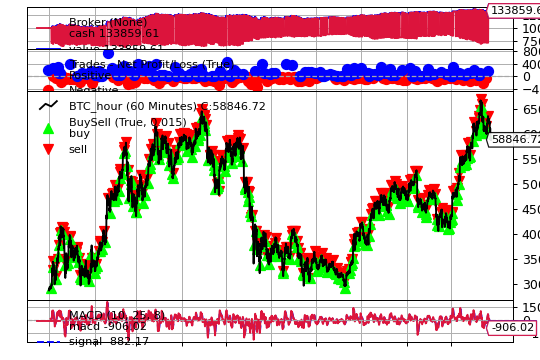

[[<Figure size 432x288 with 5 Axes>]]

In [5]:
cerebro = bt.Cerebro()
cerebro.addstrategy(zwpy_sta.MacdV2Strategy)
cerebro.broker.setcash(100000)
dt_start = datetime.strptime("2021-01-01","%Y-%m-%d")
dt_end = datetime.strptime("2021-10-28","%Y-%m-%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,           
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)
print('Starting Value: %.2f' % cerebro.broker.getvalue())

# 添加pyfolio analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Ending Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot()

## Pyfolio 計算風險指標

Start date,2021-01-01
End date,2021-10-28
Total months,14
,Backtest
Annual return,27.653%
Cumulative returns,33.86%
Annual volatility,17.04%
Sharpe ratio,1.52
Calmar ratio,2.60
Stability,0.62
Max drawdown,-10.618%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.62,2021-04-13,2021-05-23,2021-08-20,94
1,6.36,2021-02-22,2021-02-28,2021-03-07,10
2,6.23,2021-01-14,2021-01-31,2021-02-08,18
3,4.54,2021-03-14,2021-03-25,2021-04-13,22
4,3.53,2021-01-08,2021-01-13,2021-01-14,5


<IPython.core.display.Javascript object>


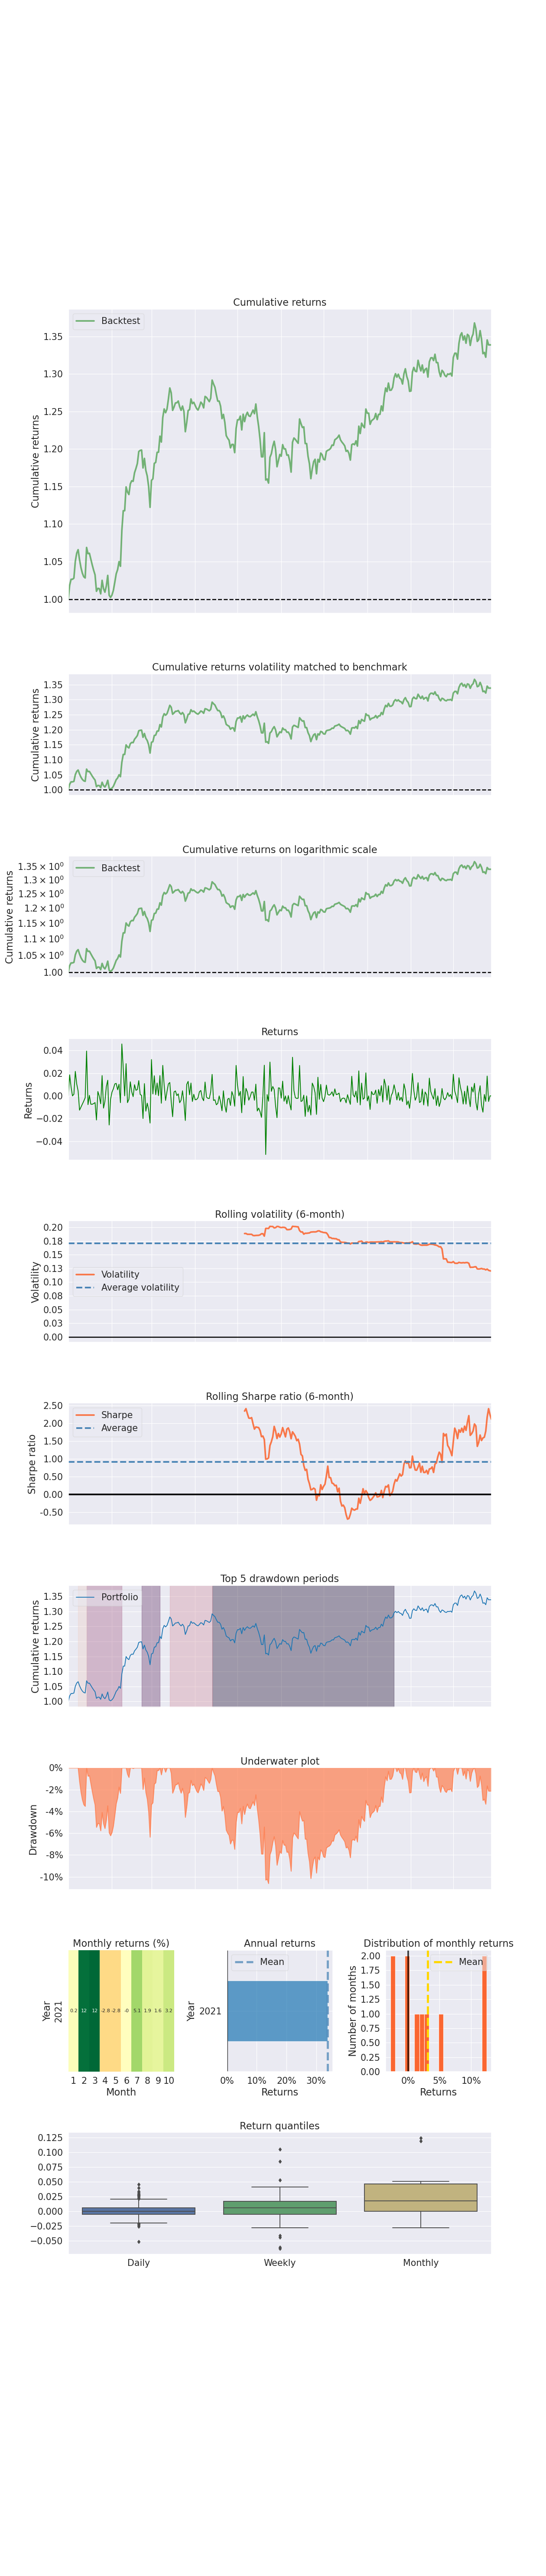

/home/thomas/Desktop/BTC/env/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,0.10%,-5.16%,4.57%


<IPython.core.display.Javascript object>


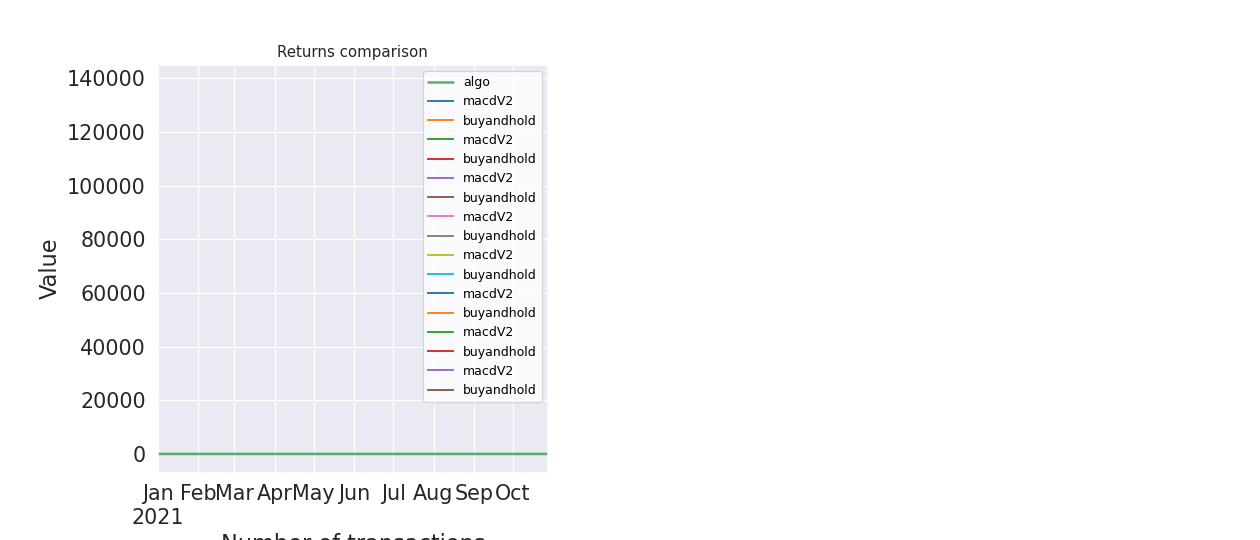

In [6]:
# backtrader 結果
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

# 把結果送進pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# 輸出各種風險指標
pf.create_full_tear_sheet(returns)

## Returns

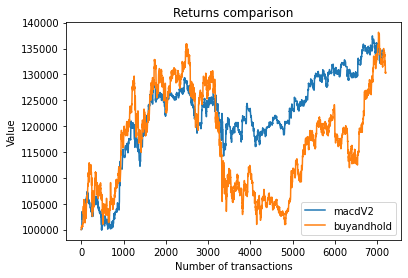

In [3]:
import matplotlib
import matplotlib.pyplot as plt

timeseries = report_folder / "compare.json"
with open(timeseries)as f:
    timeseries = json.load(f)

y1 = timeseries['timeseries']['macdV2']
y2 = timeseries['timeseries']['buyandhold']

# plot
plt.plot(range(len(y1)),y1, label="macdV2")
plt.plot(range(len(y2)),y2, label="buyandhold")
plt.xlabel('Number of transactions')
plt.ylabel('Value')
plt.title('Returns comparison')
plt.legend()
plt.show()

### 結論

    最後以回報率和夏普比率來與 buy and hold 作比較

    以回報率看這個策略沒有明顯的優勢

    再總回報上只比 buy and hold多出3.61％

    但以 sharpe ratio 來看 macdV2 是相對穩定的

> sharpe
* macdV2 : 1.52
* buy and hold : 0.93

比較見 `compare.json`